In [12]:
import pandas as pd

from eeg_analyzer.dataset import Dataset
from eeg_analyzer.processor import Processor
from utils.config import DATASETS

dataset_config = DATASETS["braboszcz2017"]

dataset = Dataset(dataset_config)
dataset.load_subjects()

results = []
for subject in dataset.get_subjects(group="vip"):
    rows = Processor.summarize_subject_alpha(subject)
    results.extend(rows)

df = pd.DataFrame(results)

→ Subject 060 session 1, task med2, state OT, alpha shape: (120, 64)
  Outlier indices: {0: [], 1: [], 2: [], 3: [], 4: [], 5: [114, 115], 6: [114, 115], 7: [], 8: [], 9: [], 10: [], 11: [], 12: [], 13: [], 14: [], 15: [], 16: [28], 17: [], 18: [], 19: [], 20: [], 21: [], 22: [], 23: [], 24: [], 25: [], 26: [], 27: [], 28: [], 29: [], 30: [], 31: [], 32: [], 33: [], 34: [], 35: [], 36: [], 37: [], 38: [], 39: [], 40: [], 41: [], 42: [], 43: [], 44: [], 45: [], 46: [], 47: [], 48: [], 49: [60, 112], 50: [60], 51: [], 52: [], 53: [], 54: [60, 112], 55: [60, 112], 56: [], 57: [], 58: [], 59: [], 60: [], 61: [], 62: [], 63: []}
→ Subject 060 session 1, task think2, state MW, alpha shape: (109, 64)
  Outlier indices: {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], 10: [], 11: [], 12: [69], 13: [27], 14: [], 15: [], 16: [27], 17: [69], 18: [45], 19: [45], 20: [], 21: [], 22: [], 23: [], 24: [], 25: [], 26: [], 27: [], 28: [], 29: [], 30: [45], 31: [45], 32: [30], 33: [

We now have a df for this dataset with all recording for all the subjects.

Dataframe structure is now: 
|dataset|subject|session|task|state|channel|alpha_power|

### Group Data by Dataset, Task, and Stack OT-MW per Recording

In [15]:
# Group data by dataset, task, and state
grouped = df.groupby(['dataset', 'task', 'state', 'channel'])

# Stack OT-MW per recording
stacked_data = {}
for (dataset, task, state, channel), group in grouped:
    key = (dataset, channel)
    if key not in stacked_data:
        stacked_data[key] = {'OT': [], 'MW': []}
    stacked_data[key][state].extend(group['alpha_power'].values)

### Perform Mann-Whitney U Test per Channel

In [18]:
from scipy.stats import mannwhitneyu

results = []
for (dataset, channel), data in stacked_data.items():
    if len(data['OT']) > 0 and len(data['MW']) > 0:
        u_stat, p = mannwhitneyu(data['OT'], data['MW'], alternative='less')
        results.append({'dataset': dataset, 'channel': channel, 'p_value': p})

# Convert results to a DataFrame for visualization
results_df = pd.DataFrame(results)

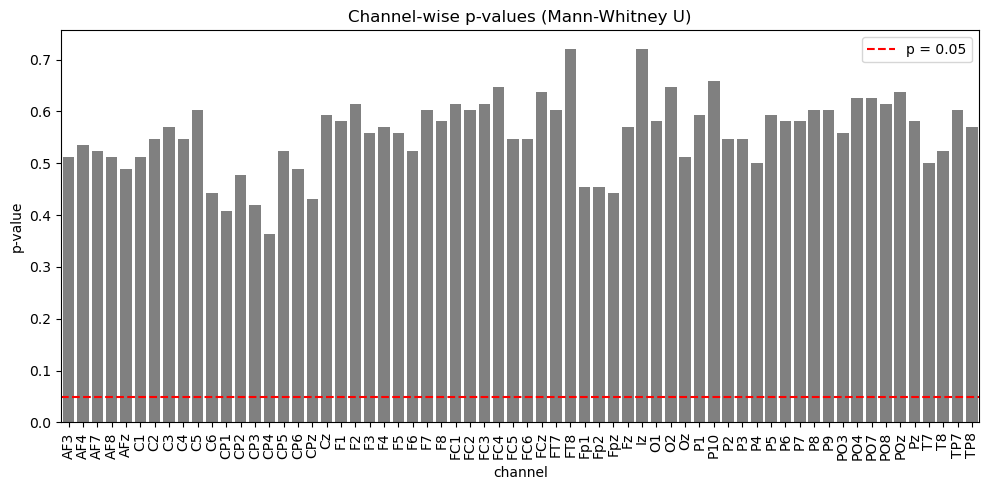

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.barplot(data=results_df, x="channel", y="p_value", color="grey")
plt.axhline(0.05, color="red", linestyle="--", label="p = 0.05")
plt.title("Channel-wise p-values (Mann-Whitney U)")
plt.xticks(rotation=90)
plt.ylabel("p-value")
plt.legend()
plt.tight_layout()
plt.show()


### Count Comparisons of OT > MW and MW > OT Alpha Power

In [20]:
comparison_results = []

for (dataset, task, channel), data in stacked_data.items():
    ot_greater = sum(ot > mw for ot, mw in zip(data['OT'], data['MW']))
    mw_greater = sum(mw > ot for ot, mw in zip(data['OT'], data['MW']))
    comparison_results.append({
        'dataset': dataset,
        'task': task,
        'channel': channel,
        'OT > MW': ot_greater,
        'MW > OT': mw_greater
    })

# Convert comparison results to a DataFrame
comparison_df = pd.DataFrame(comparison_results)

# Print summary
print(comparison_df.groupby(['dataset', 'task'])[['OT > MW', 'MW > OT']].sum())

ValueError: not enough values to unpack (expected 3, got 2)